2nd Laboratory work

Student - Vadim Čeremisinov, 4th group
Student ID - 2110545 

Chosen classes for classification: Banana, Duck, Sea lion

Needed Libraries:

In [12]:
import torch
from torchvision import datasets
from torchvision.transforms import transforms
import PIL
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Switching to GPU, if not atvailable -> cpu:

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Data loading:

Transformation of photos for classification model.

In [14]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=PIL.Image.BILINEAR),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.1, 0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4455, 0.4473, 0.3930], std=[0.2707, 0.2667, 0.2731]),
])

Each data set is being loaded from different foalders with photos:

In [15]:
train_dataset = datasets.ImageFolder(root='train', transform=transform)
validation_dataset  = datasets.ImageFolder(root='validation', transform=transform)
test_dataset = datasets.ImageFolder(root='test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0)

Counting Standard deviation and Mean average that are used for photos normalization in transforms.Normalize() function:

In [45]:
dataset = datasets.ImageFolder(root='data', transform=transform)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=0)

mean = torch.zeros(3)
total_images = 0

total_images = 0

for images, _ in validation_loader:
    batch_samples = images.size(0)  # Number of images in the batch
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    total_images += batch_samples

mean /= total_images

var = torch.zeros(3)
for images, _ in validation_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0, 2])

var /= (total_images * 256 * 256)
std = torch.sqrt(var)

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.4455, 0.4473, 0.3930])
Std: tensor([0.2707, 0.2667, 0.2731])


### Convolutional Neuron Network model

Using dropout function to avoid overfitting (overtraining), also for this purpose using bigger amount of parametrs at the last layer.

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 3)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = self.flatten(x)
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


Calculating the number of parameters (for fun):

In [49]:
number = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("number of unknown parameters: {}".format(number))

number of unknown parameters: 33580067


### Loss function with gradient, learning rate is 0.001: 

In [17]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Training the Model

The number of epochs used in training was controlled statically (hard coded), while now it is controlled dynamically by using Early stop method. So, the static method could be deleted (can delete the line of epochs number declaration). 

First the model is being trained with training dataset, then model's accuracy and loss function is being tested and counted with validation dataset. After training the model, it's accuracy is being tested with testing dataset.

In [18]:
# Setting epochs statically 
#n_epochs = 30
epoch = 0
# Model is being transfered to CPU or GPU
model.to(device)

# Creating lists for training and validaton accuracies and losses (liet. nuostoliai/paklaidos) storage
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

# Defining early stop level
early_stopping_patience = 3
early_stopping_counter = 0
best_val_loss = np.inf

while True:
    model.train()

    train_loss = 0.0
    validation_loss = 0.0
    train_acc = 0.0
    validation_acc = 0.0

    # At the 0 epoch the gradient counting is being turned off
    if epoch == 0:
      torch.set_grad_enabled(False)

    # Training phase
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(images)

        with torch.no_grad():
            outputLabels = torch.argmax(outputs, 1)
            accuracy = labels == outputLabels
            train_acc += torch.sum(accuracy.float()).item()

        loss = loss_func(outputs, labels)

        # If not 0 epoch, update the model
        if epoch != 0:
            loss.backward()     # Updating gradients
        optimizer.step()    # Updating the weights' values

        train_loss += loss.item() * images.size(0)


    # Validation phase
    model.eval()
    with torch.no_grad():
      for data in validation_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)
          loss = loss_func(outputs, labels)
          validation_loss += loss.item() * images.size(0)

          outputLabels = torch.argmax(outputs, 1)
          accuracy = labels == outputLabels
          validation_acc += torch.sum(accuracy.float()).item()

    # Counting average training and validation losses and accuracy rates/values
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_val_loss = validation_loss / len(validation_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    avg_val_acc = validation_acc / len(validation_loader.dataset)

    # Adding the results of epoches to the lists
    train_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_acc)
    validation_accuracies.append(avg_val_acc)

    print('Epoch: {} \t Training Loss: {:.10f} \t Training Accuracy: {:.5f} \t Validation Loss: {:.10f} \t Validation Accuracy: {:.5f}'.format(
        epoch,
        avg_train_loss,
        avg_train_acc,
        avg_val_loss,
        avg_val_acc,
        ))
    
    # Checking for Early Stop option (if it is needed)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered. Stopping training...")
            break
    
    if epoch == 0:
      torch.set_grad_enabled(True)

    epoch += 1

# Testing phase
test_loss = 0.0
test_acc = 0.0

model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        test_loss += loss.item() * images.size(0)

        outputLabels = torch.argmax(outputs, 1)
        accuracy = labels == outputLabels
        test_acc += torch.sum(accuracy.float()).item()

avg_test_loss = test_loss / len(test_loader.dataset)
avg_test_acc = test_acc / len(test_loader.dataset)

print('Testing loss (unseen data): {:.10f} \t Testing accuracy: {:.5f}'.format(
    avg_test_loss, avg_test_acc
))

Epoch: 0 	 Training Loss: 1.1159560163 	 Training Accuracy: 0.12156 	 Validation Loss: 1.1105784036 	 Validation Accuracy: 0.11912
Epoch: 1 	 Training Loss: 1.2417250358 	 Training Accuracy: 0.58563 	 Validation Loss: 0.7500227940 	 Validation Accuracy: 0.68652
Epoch: 2 	 Training Loss: 0.7317394400 	 Training Accuracy: 0.71860 	 Validation Loss: 0.6750722118 	 Validation Accuracy: 0.73668
Epoch: 3 	 Training Loss: 0.6796828426 	 Training Accuracy: 0.73271 	 Validation Loss: 0.7317959246 	 Validation Accuracy: 0.70533
Epoch: 4 	 Training Loss: 0.6519460936 	 Training Accuracy: 0.74882 	 Validation Loss: 0.6569156475 	 Validation Accuracy: 0.74608
Epoch: 5 	 Training Loss: 0.6432166652 	 Training Accuracy: 0.73405 	 Validation Loss: 0.7154390449 	 Validation Accuracy: 0.72727
Epoch: 6 	 Training Loss: 0.6009653047 	 Training Accuracy: 0.74950 	 Validation Loss: 0.6254684054 	 Validation Accuracy: 0.75235
Epoch: 7 	 Training Loss: 0.5936891849 	 Training Accuracy: 0.77032 	 Validation Lo

### Checking if the Model is Overfitting (overtrained) or underfitting

Overfitting example - Training loss is low and Validation loss in high, the gap is big between them, so the model just remembers training data
Underfitting example - On both Training and Validation the loss is too high, and the gap between them is pretty small.

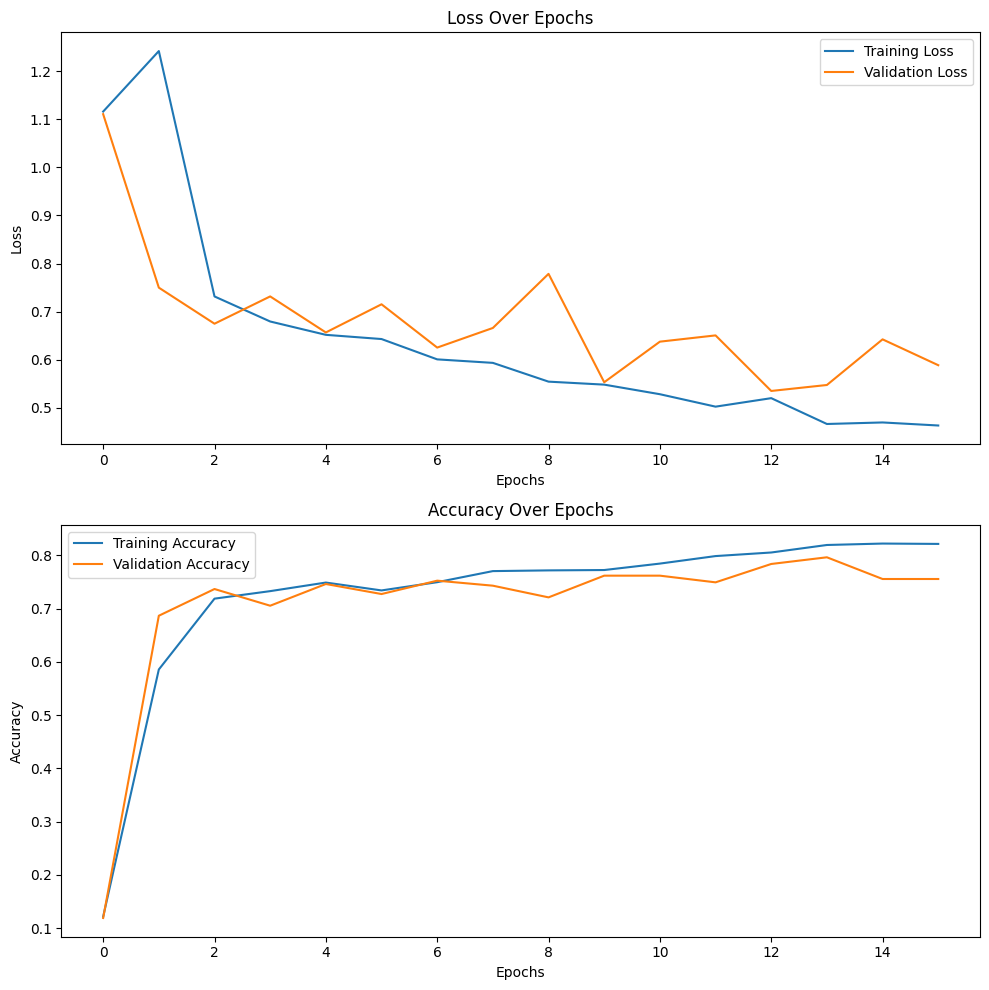

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(validation_losses, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss Over Epochs')
axs[0].legend()

axs[1].plot(train_accuracies, label='Training Accuracy')
axs[1].plot(validation_accuracies, label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy Over Epochs')
axs[1].legend()

plt.tight_layout()
plt.show()

### Saving the Model and Loading it

In [20]:
torch.save(model.state_dict(), "model.pth")

In [21]:
test_model = CNN()
test_model.load_state_dict(torch.load("model.pth"))
test_model.to(device)
test_model

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

### Counting Statistics
Counting metrics:
* Confusion matrix
* Accuracy
* Precission
* Recall
* F1

Classification Report:
              precision    recall  f1-score   support

      banana       0.77      0.63      0.69        89
        duck       0.75      0.87      0.81       194
    sea lion       0.57      0.34      0.43        38

    accuracy                           0.74       321
   macro avg       0.69      0.61      0.64       321
weighted avg       0.73      0.74      0.73       321

Accuracy: 0.74143
Precision: 0.73354
Recall: 0.74143
F1 Score: 0.72967

Confusion Matrix:
[[ 56  32   1]
 [ 16 169   9]
 [  1  24  13]]


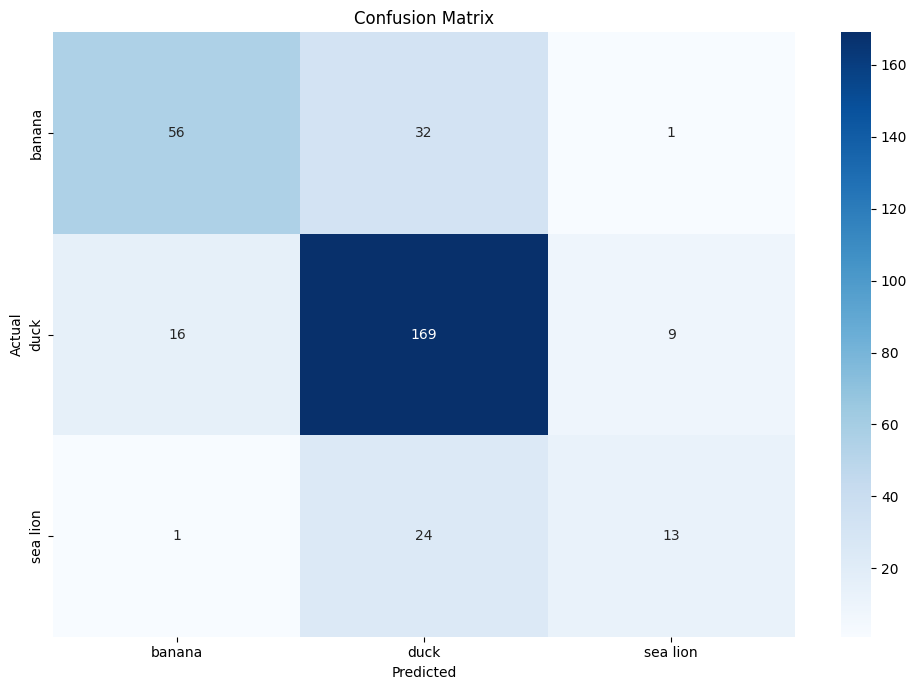

In [22]:
test_model.eval()

predicted_classes = []
true_classes = []

# Testing the model with testing dataset in order to get statistics
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = test_model(inputs)
        _, preds = torch.max(outputs, 1)
        predicted_classes.extend(preds.cpu().numpy())
        true_classes.extend(labels.cpu().numpy())

class_labels = list(test_loader.dataset.class_to_idx.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Calculating metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1 Score: {f1:.5f}")

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Matrix visualization
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix') 

plt.tight_layout()
plt.show()